[*********************100%***********************]  1 of 1 completed


Index(['Volume', 'MACD_HIST', 'Target'], dtype='object', name='Price')
Optimization terminated successfully.
         Current function value: 0.689678
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 8278
Model:                          Logit   Df Residuals:                     8275
Method:                           MLE   Df Model:                            2
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:               0.0001616
Time:                        11:40:20   Log-Likelihood:                -5709.2
converged:                       True   LL-Null:                       -5710.1
Covariance Type:            nonrobust   LLR p-value:                    0.3973
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1439      0.030     

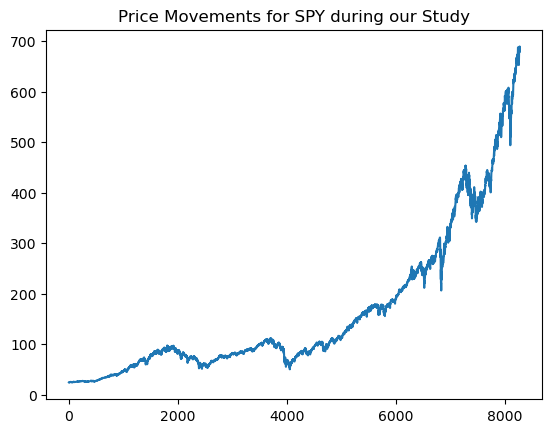

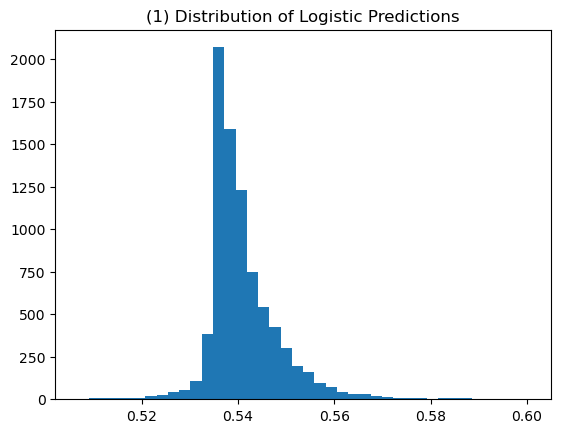

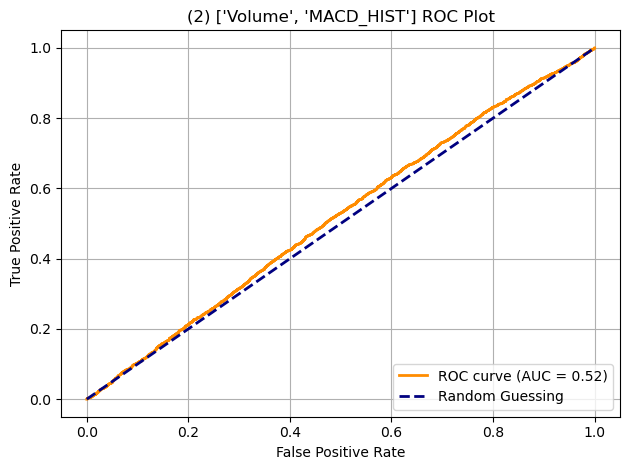

Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_HIST,Close + 1,Target,Prediction
0,24.313046,24.330338,24.209291,24.330338,1003200,24.313046,24.313046,0.000000,0.000000,0.000000,24.485964,1,0
1,24.485964,24.485964,24.330333,24.330333,480500,24.406710,24.402707,0.004003,0.002224,0.001779,24.537832,1,0
2,24.537832,24.555125,24.416786,24.468663,201300,24.457887,24.451125,0.006762,0.004084,0.002678,24.797220,1,0
3,24.797220,24.814513,24.555127,24.572420,529400,24.565001,24.547491,0.017510,0.008632,0.008878,24.900986,1,0
4,24.900986,24.952863,24.607016,24.883693,531500,24.656287,24.629036,0.027251,0.014171,0.013080,24.883673,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8273,687.570007,688.969971,681.309998,682.559998,85671300,681.128640,677.043817,4.084823,2.812731,1.272091,689.169983,1,0
8274,689.169983,689.250000,682.169983,685.140015,86173700,682.365770,677.909972,4.455798,3.141345,1.314453,681.760010,0,0
8275,681.760010,688.880005,679.169983,688.169983,113160300,682.272576,678.184975,4.087601,3.330596,0.757005,680.729980,0,0
8276,680.729980,685.760010,679.250000,685.739990,90811000,682.035253,678.366761,3.668493,3.398175,0.270317,678.869995,0,0


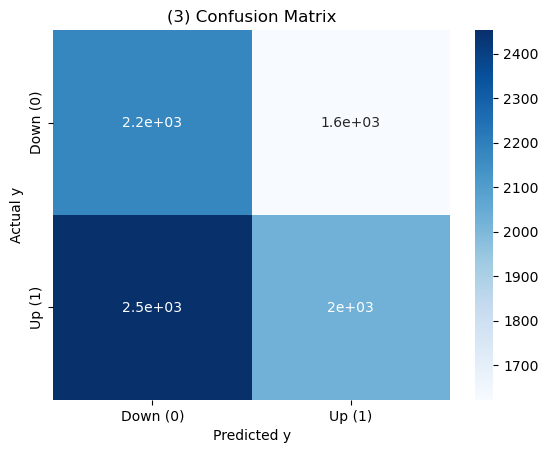

In [ ]:
import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc # pip install scikit-learn
from curl_cffi import requests # pip install curl_cffi

TICKER = "SPY"

INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

SHIFT = 1 
LOOKBACK = 10000

STRATEGY = ["Volume", "MACD_HIST"]

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

SESSION = requests.Session(impersonate="chrome")

def get_data(ticker = TICKER, session = SESSION, interval = INTERVAL, lookback = LOOKBACK):

    df = yf.download(ticker, session = session, interval = interval, period = PERIOD)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    plt.figure()
    plt.plot(df["Close"])
    plt.title(f"Price Movements for {ticker} during our Study")

    return df.iloc[-lookback:, :]

# Add Features
def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

# Add Target 
def add_target(df, shift = SHIFT):

    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1

    return df

# --- (5) Generate Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):

    subset = df[features + [target]].dropna()
    print(subset.columns)
    X = subset[features] 
    y = subset[target] 
    X_with_const = sm.add_constant(X)
    
    model = sm.Logit(y, X_with_const).fit()

    # We need the predicted Values of y. 
    y_pred_prob = model.predict(X_with_const)
    plt.figure()
    plt.hist(y_pred_prob, bins = 40)
    plt.title("(1) Distribution of Logistic Predictions")
    ## Everything left to 0.5 will be a 0 and everything right to 0.5 will be a 1
    # A perefct distribution would be ceneterd around 0.5, but that is rare, because most datasets are skewed

    y_pred = (y_pred_prob > .54).astype(int) # List of responses that are either 0 or 1
    # we can change our cutoff to above the mean, .54 and with that we can actually have a better distribution, 
    # as well as a confucion matrix, so the model becomes a little bit more useful 
    
    # Console Summary
    print(model.summary())
    df["Prediction"] = y_pred

    return df, y, y_pred_prob


def add_confusion_matrix(df):

    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()

    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

    ## Understanding this Confusion Matrix

    return df

# ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(df, y_true, y_scores, title=f"(2) {STRATEGY} ROC Plot"):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def main():

    df = get_data()
    df = add_MACD(df)
    df = add_target(df)
    df, y, y_pred_prob = generate_regression_output(df)
    df = add_roc_plot(df, y_true=y, y_scores=y_pred_prob)
    df = add_confusion_matrix(df)

    return df 

df = main()
df


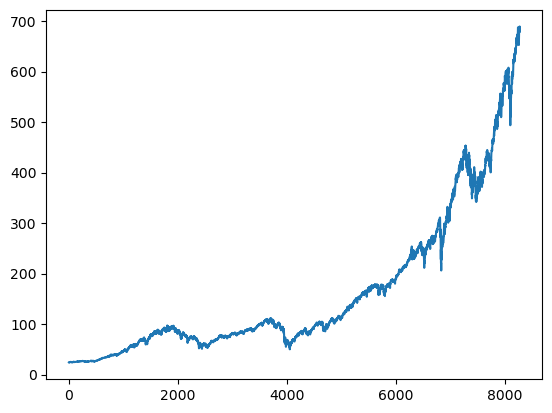

In [45]:
# Lets examine the Environment of our Study
plt.plot(df["Close"])
# As we can see, more often than not, the prices go up more than they go down 

In [46]:
df["Prediction"].value_counts()
# Down Days are rare, but they do stillm exist

Prediction
0    4631
1    3647
Name: count, dtype: int64